# Data Augmentation

## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from random import sample
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

## 3.1 Try some augmentation technique on base image 

### Original Image

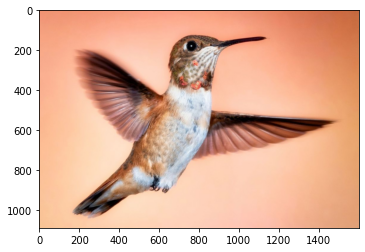

In [ ]:
image = load_img('/content/test.jpg')
plt.imshow(image)

In [ ]:
def generate_images(img, image_counts, rotation_range=90, width_shift_range=0.2, 
                    height_shift_range=0.2, shear_range=0.2, zoom_range=0.3, 
                    horizontal_flip=True, vertical_flip=True, 
                    brightness_range=[0.5,1]):
  images = []
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(
      rotation_range=rotation_range,
      width_shift_range=width_shift_range,
      height_shift_range=height_shift_range,
      shear_range=shear_range,
      zoom_range=zoom_range,
      horizontal_flip=horizontal_flip,
      vertical_flip=vertical_flip,
      brightness_range=brightness_range)
  it = datagen.flow(samples, batch_size=1)  
  for i in range(image_counts):
    batch = it.next()
    new_image = batch[0].astype('uint8')
    images.append(new_image)
  return images

In [ ]:
new_images = generate_images(image, 10)

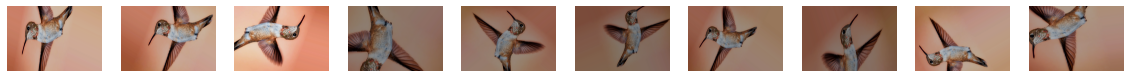

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
for i in range(len(new_images)):
  row = i  // 10
  column = i % 10
  ax[column].imshow(new_images[i])
  ax[column].axis('off')
plt.show()

## 3.2 Reduce Data

### Load Cifar10

In [ ]:
transformer = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

batch_size = 4
train_data = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                          download=True, transform=transformer)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                         download=True, transform=transformer)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


### Reduce Cat and Dog classes data

In [ ]:
classes = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

In [ ]:
def get_classes_indices(data_tensor):
  data = data_tensor.data
  targets = data_tensor.targets
  class_indices = {}
  for index, id in enumerate(targets):
    if id not in class_indices:
      class_indices[id] = list()
    class_indices[id].append(index)
  return class_indices

In [ ]:
classes_indices = get_classes_indices(train_data)

In [ ]:
def get_selected_indices_after_reduction(data_tensor, classes_count, class_indices):
  selected_indices = {}
  for class_id, class_index in class_indices.items():
    if class_id in classes_count:
      class_count = classes_count[class_id]
      class_selected_indices = sample(class_index, class_count)
      selected_indices[class_id] = class_selected_indices
    else:
      selected_indices[class_id] = class_index
  return selected_indices

In [ ]:
selected_indices = get_selected_indices_after_reduction(train_data, {classes['cat']: 500, classes['dog']: 500}, classes_indices)

In [ ]:
def downsample_some_class(data_tensor, selected_indices):
  reduced_data = torch.utils.data.Subset(train_data, selected_indices)
  return reduced_data

In [ ]:
reduced_train_data = downsample_some_class(train_data, np.concatenate(list(selected_indices.values())))

In [ ]:
reduced_train_loader = torch.utils.data.DataLoader(reduced_train_data, batch_size=batch_size, shuffle=True)

### Run Reduced Model

In [ ]:
class BestCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Filter Layer 1
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=72, kernel_size=4, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        # Filter Layer 2
        self.conv21 = nn.Conv2d(in_channels=72, out_channels=120, kernel_size=3, padding=1, stride=1)
        self.conv22 = nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Filter Layer 3
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=45, kernel_size=2, padding=1, stride=1)
        self.conv32 = nn.Conv2d(in_channels=45, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.ReLU = nn.ReLU()

    def forward(self, input):
        # Filter Layer 1
        input = self.conv11(input)
        input = self.ReLU(input)
        input = self.conv12(input)
        input = self.ReLU(input)
        input = self.pool1(input)

        # Filter Layer 2
        input = self.conv21(input)
        input = self.ReLU(input)
        input = self.conv22(input)
        input = self.ReLU(input)
        input = self.pool2(input)

        # Filter Layer 3
        input = self.conv31(input)
        input = self.ReLU(input)
        input = self.conv32(input)
        input = self.ReLU(input)
        input = self.pool3(input)

        input = torch.flatten(input, 1)
        # Fully connected layers
        input = self.fc1(input)
        input = self.ReLU(input)
        input = self.fc2(input)
        input = self.ReLU(input)
        input = self.fc3(input)

        return input

In [ ]:
def train(model, train_loader, test_loader, epochs_num, optimizer, loss_function, train_size, test_size):
  epochs_train_loss = []
  epochs_test_loss = []
  epochs_train_acc = []
  epochs_test_acc = []
  for epoch in range(1, epochs_num+1):
    batches_train_loss = []
    batches_train_predictions = []
    batches_train_targets = []

    for index, data in enumerate(train_loader):
      features, targets = data
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      output = model(features)
      _, prediction = torch.max(output.data, 1)

      loss = loss_function(output, targets)

      loss.backward()
      optimizer.step()

      batches_train_loss.append(loss.item())

      batches_train_predictions.extend(prediction.cpu())
      batches_train_targets.extend(targets.cpu())

      if (index+1) % 2000==0:
          print("Batch number {} is finished!".format(index+1))
    
    batches_test_predictions, batches_test_targets, batches_test_loss = test(model, test_loader, optimizer, loss_function)
    epochs_train_acc.append(accuracy_score(batches_train_targets, batches_train_predictions))
    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)

    epochs_test_acc.append(accuracy_score(batches_test_targets, batches_test_predictions))
    epochs_test_loss.append(np.sum(batches_test_loss)/test_size)

    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, epochs_test_loss, epochs_train_acc, epochs_test_acc

In [ ]:
def test(model, test_loader, optimizer, loss_function):
  batches_test_loss = []
  batches_test_predictions = []
  batches_test_targets = []
  with torch.no_grad():
    for features, target in test_loader:
      features, target = features.cuda(), target.cuda()
      output = model(features)
      _, prediction = torch.max(output.data, 1)
      loss = loss_function(output, target).item()
      batches_test_loss.append(loss)
      batches_test_predictions.extend(prediction.cpu())
      batches_test_targets.extend(target.cpu())
    
  return batches_test_predictions, batches_test_targets, batches_test_loss

In [ ]:
def plot_result(epochs_train, epochs_test, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'test']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train)
  plt.plot(x_axis, epochs_test)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

In [ ]:
reduced_net = BestCNN()
reduced_net.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
reduced_optimizer = optim.SGD(reduced_net.parameters(), lr=0.001, momentum=0.9)
reduced_epochs_train_loss, reduced_epochs_test_loss, reduced_epochs_train_acc, reduced_epochs_test_acc = train(reduced_net, reduced_train_loader, test_loader, 10, reduced_optimizer, criterion, len(reduced_train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Epoch 5 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is f

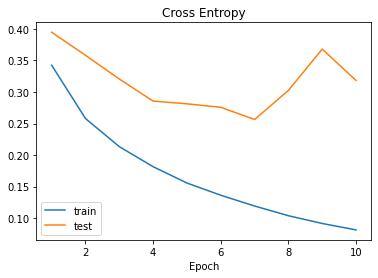

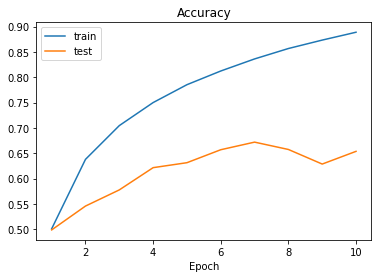

In [ ]:
plot_result(reduced_epochs_train_loss, reduced_epochs_test_loss, 10, "Cross Entropy")
plot_result(reduced_epochs_train_acc, reduced_epochs_test_acc, 10, "Accuracy")

### Confusion Matrix of Test Data

In [ ]:
reduced_test_predictions, reduced_test_targets, reduced_test_loss = test(reduced_net, test_loader, reduced_optimizer, criterion)

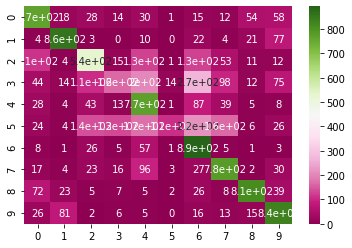

In [ ]:
reduced_test_confusion_matrix = confusion_matrix(y_true = reduced_test_targets, y_pred = reduced_test_predictions)
sns.heatmap(reduced_test_confusion_matrix, cmap="PiYG", annot=True)

### Calculate each class accuracy

In [ ]:
for class_id in range(10):
  class_accuracy = reduced_test_confusion_matrix[class_id][class_id] / sum(reduced_test_confusion_matrix[class_id])
  print("Class {} accuracy: {:.2f}%".format(class_id, class_accuracy))

Class 0 accuracy: 0.77%
Class 1 accuracy: 0.86%
Class 2 accuracy: 0.54%
Class 3 accuracy: 0.16%
Class 4 accuracy: 0.77%
Class 5 accuracy: 0.11%
Class 6 accuracy: 0.89%
Class 7 accuracy: 0.78%
Class 8 accuracy: 0.81%
Class 9 accuracy: 0.84%


## 3.4 Increase Data by Data Augumentation

In [ ]:
def increase_data(base_images, extended_count=9):
  new_images = []
  for index, bases_image in enumerate(base_images):
    new_images.extend(generate_images(bases_image, extended_count))
  return new_images

In [ ]:
base_images = {}
base_images[classes['cat']] = [train_data.data[i] for i in selected_indices[classes['cat']]]
base_images[classes['dog']] = [train_data.data[i] for i in selected_indices[classes['dog']]]

In [ ]:
augmented_data = {}
augmented_data[classes['cat']] = increase_data(base_images[classes['cat']])

In [ ]:
augmented_data[classes['dog']] = increase_data(base_images[classes['dog']])

In [ ]:
replace_indices = {}
replace_indices[classes['cat']] = [i for i in classes_indices[classes['cat']] 
                                   if i not in selected_indices[classes['cat']]]
replace_indices[classes['dog']] = [i for i in classes_indices[classes['dog']] 
                                   if i not in selected_indices[classes['dog']]]

In [ ]:
def replace_indices_with_new_data(dataset, indices, new_data):
  for new_data_index, dataset_index in enumerate(indices):
    dataset.data[dataset_index] = new_data[new_data_index]

In [ ]:
replace_indices_with_new_data(train_data, replace_indices[classes['cat']], 
                              augmented_data[classes['cat']])

In [ ]:
replace_indices_with_new_data(train_data, replace_indices[classes['dog']], 
                              augmented_data[classes['dog']])

### Run Model with Augmented Data

In [ ]:
augmented_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
augmented_net = BestCNN()
augmented_net.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
augmented_optimizer = optim.SGD(augmented_net.parameters(), lr=0.001, momentum=0.9)
augmented_epochs_train_loss, augmented_epochs_test_loss, augmented_epochs_train_acc, augmented_epochs_test_acc = train(augmented_net, augmented_train_loader, test_loader, 10, augmented_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

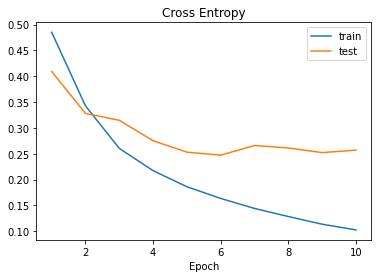

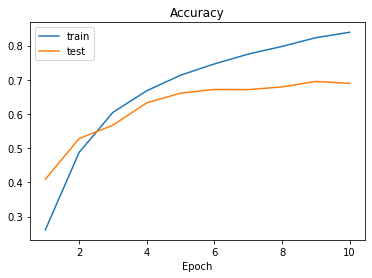

In [ ]:
plot_result(augmented_epochs_train_loss, augmented_epochs_test_loss, 10, "Cross Entropy")
plot_result(augmented_epochs_train_acc, augmented_epochs_test_acc, 10, "Accuracy")

### Confusion Matrix of Test Data

In [ ]:
augmented_test_predictions, augmented_test_targets, augmented_test_loss = test(augmented_net, test_loader, augmented_optimizer, criterion)

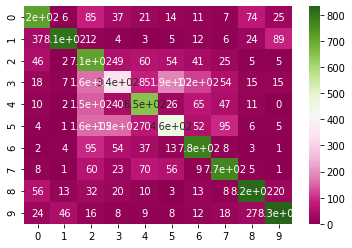

In [ ]:
augmented_test_confusion_matrix = confusion_matrix(y_true = augmented_test_targets, y_pred = augmented_test_predictions)
sns.heatmap(augmented_test_confusion_matrix, cmap="PiYG", annot=True)

### Calculate each class accuracy

In [ ]:
for class_id in range(10):
  class_accuracy = augmented_test_confusion_matrix[class_id][class_id] / sum(augmented_test_confusion_matrix[class_id])
  print("Class {} accuracy: {:.2f}%".format(class_id, class_accuracy))

Class 0 accuracy: 0.72%
Class 1 accuracy: 0.81%
Class 2 accuracy: 0.71%
Class 3 accuracy: 0.34%
Class 4 accuracy: 0.65%
Class 5 accuracy: 0.46%
Class 6 accuracy: 0.78%
Class 7 accuracy: 0.77%
Class 8 accuracy: 0.82%
Class 9 accuracy: 0.83%


In [ ]:
augmented_20_net = BestCNN()
augmented_20_net.cuda()
criterion = nn.CrossEntropyLoss()
augmented_20_optimizer = optim.SGD(augmented_20_net.parameters(), lr=0.001, momentum=0.9)
augmented_20_epochs_train_loss, augmented_20_epochs_test_loss, augmented_20_epochs_train_acc, augmented_20_epochs_test_acc = train(augmented_20_net, augmented_train_loader, test_loader, 20, augmented_20_optimizer, criterion, len(train_data), len(test_data))

Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 1 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 2 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 3 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch number 12000 is finished!
Epoch 4 is finished!
Batch number 2000 is finished!
Batch number 4000 is finished!
Batch number 6000 is finished!
Batch number 8000 is finished!
Batch number 10000 is finished!
Batch nu

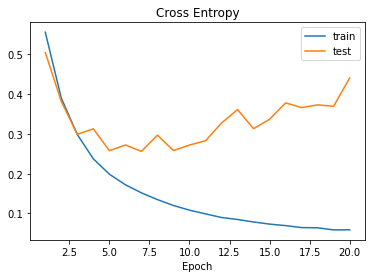

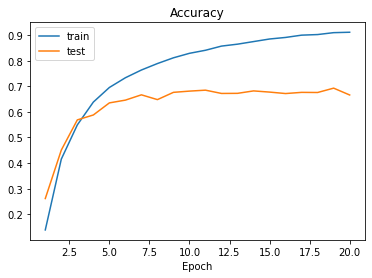

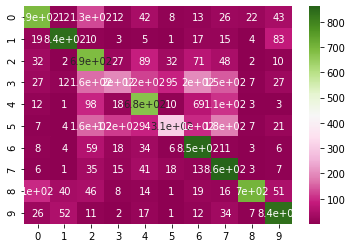

In [ ]:
plot_result(augmented_20_epochs_train_loss, augmented_20_epochs_test_loss, 20, "Cross Entropy")
plot_result(augmented_20_epochs_train_acc, augmented_20_epochs_test_acc, 20, "Accuracy")
augmented_20_test_predictions, augmented_20_test_targets, augmented_20_test_loss = test(augmented_20_net, test_loader, augmented_20_optimizer, criterion)
augmented_20_test_confusion_matrix = confusion_matrix(y_true = augmented_20_test_targets, y_pred = augmented_20_test_predictions)
sns.heatmap(augmented_20_test_confusion_matrix, cmap="PiYG", annot=True)

In [ ]:
for class_id in range(10):
  class_accuracy = augmented_20_test_confusion_matrix[class_id][class_id] / sum(augmented_20_test_confusion_matrix[class_id])
  print("Class {} accuracy: {:.2f}%".format(class_id, class_accuracy))

Class 0 accuracy: 0.69%
Class 1 accuracy: 0.84%
Class 2 accuracy: 0.69%
Class 3 accuracy: 0.20%
Class 4 accuracy: 0.68%
Class 5 accuracy: 0.31%
Class 6 accuracy: 0.85%
Class 7 accuracy: 0.86%
Class 8 accuracy: 0.70%
Class 9 accuracy: 0.84%
